<h1 style="text-align: center;">
    Excess mortality - final analysis - NPI Paper
</h1>

Compute weekly excess mortality in 2020 - 2022 in 13 western European countries : Belgium, Denmark, France, Germany, Ireland, Italy, Netherlands, Norway, Portugal, Spain, Sweden, Switzerland, United Kingdom. The methodology used is the one unsed by the Institute and Faculties of Actuaries in the CMI working paper 180 (https://www.actuaries.org.uk/learn-and-develop/continuous-mortality-investigation/cmi-working-papers/mortality-projections/cmi-working-paper-180). The only difference is that they carried forward the predicted 2019 age- and sex-standardised mortality rate to estimate the expected mortality in 2020-2022, whereas we chose the projected valued for 2020-2022 based on the model to compute expected mortality in these same years, aiming to account for the long-term decrease in mortality rates.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta

<h1 style="text-align: left; color: coral;">
    I- Data opening 
</h1>

In [2]:
#path to change if other user (work repository path)
path_user = "C:\\Users\\ccoustau\\Documents\\NPI\\NPI - Excess mortality\\"

Country_dic = {'Belgium':'BEL', 'Denmark':'DNK', 'France':'FRATNP', 'Germany':'DEUTNP', 'Italy':'ITA', 'Netherlands':'NLD', 
               'Norway':'NOR', 'Portugal':'PRT', 'Spain':'ESP', 'Sweden':'SWE', 'Switzerland':'CHE', 'England + Wales':'GBRTENW', 'United Kingdom':'UK'}

Country = ['Belgium', 'Denmark', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']
Country_ireland = ['Belgium', 'Denmark', 'France', 'Germany', 'Italy', 'Ireland', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']

age_cat = ['0-14','15-64','65-74','75-84','85+']
age_cat_total = ['0-14','15-64','65-74','75-84','85+','Total']

n_week = {2010:52, 2011:52, 2012:52, 2013:52, 2014:52, 2015:53, 2016:52, 2017:52, 2018:52, 2019:52, 2020:53, 2021:52, 2022:52}

<h2 style="text-align: left; color: skyblue;">
    I-1) HMD database
</h2>

Data used : Human Mortality Database (HMD) - short-term mortality fluctuations (STMF) dataset  
STMF dataset includes weekly death counts and weekly mortality rates (annualised by HMD) by gender (male and female) and age band (ages 0-14, 15-64, 65-74, 75-84 and 85+) for 38 international territories  
Data source : https://www.mortality.org/Data/STMF dowloaded on the 15/02/2024

**Data from HMD was not available for Ireland** and subdivided for UK (England & Wales, Northern Ireland, Scotland) 

For Ireland : we used data from the Irish Central Statistics Office. We used monthly death counts from 2010 to 2021, quaterly death counts for 2022 and population estimate. Data source : https://data.cso.ie/table/VSD39; https://data.cso.ie/product/VSDR; https://data.cso.ie/table/PEA01  

For UK : We aggregated regional mortality data, weighted by the number of inhabitants.

In [3]:
path_HMD_data = path_user + "stmf.xlsx"
sheet_name = 'DNK'
df = pd.read_excel(path_HMD_data, sheet_name=sheet_name)
df.head()

,Country,Year,Week,Sex,Death counts 0-14,Death counts 15-64,Death counts 65-74,Death counts 75-84,Death counts 85+,Death counts Total,Death rates 0-14,Death rates 15-64,Death rates 65-74,Death rates 75-84,Death rates 85+,Death rates Total,Split,SplitSex,Forecast
0,DNK,2007,1,m,2,143,100,176,115,536,0.000201,0.004087,0.023597,0.079887,0.187783,0.010305,0,0,0
1,DNK,2007,1,f,1,102,89,186,259,637,0.000105,0.002970,0.019190,0.060034,0.179906,0.012016,0,0,0
2,DNK,2007,1,b,3,245,189,362,374,1173,0.000154,0.003533,0.021294,0.068285,0.182256,0.011169,0,0,0
3,DNK,2007,2,m,3,124,127,171,138,563,0.000301,0.003544,0.029969,0.077617,0.225340,0.010825,0,0,0
4,DNK,2007,2,f,2,77,94,202,271,646,0.000211,0.002242,0.020268,0.065199,0.188241,0.012186,0,0,0


<h2 style="text-align: left; color: skyblue;">
    I-2) Ireland data
</h2>

In [4]:
path_Ireland_data = path_user + "monthly_deaths_pop_ireland.xlsx"
sheet_name = 'data'
data_ireland = pd.read_excel(path_Ireland_data, sheet_name=sheet_name)
data_ireland.head()

,year,month,sex,age_cat,deaths,population,death rate
0,2010,January,b,0-14,35.0,976600.0,0.000430
1,2010,January,b,15-64,569.0,3066600.0,0.002227
2,2010,January,b,65-74,485.0,302200.0,0.019259
3,2010,January,b,75-84,903.0,171200.0,0.063294
4,2010,January,b,85+,960.0,58200.0,0.197938


<h2 style="text-align: left; color: skyblue;">
    I-3) UK data aggregation
</h2>

In [5]:
def death_rate_UK(path_HMD_data):
    data_UK = pd.read_excel(path_user + 'stmf.xlsx', sheet_name='UK')
    data_engwales = pd.read_excel(path_HMD_data, sheet_name='GBRTENW')
    data_nir = pd.read_excel(path_HMD_data, sheet_name='GBR_NIR')
    data_sco = pd.read_excel(path_HMD_data, sheet_name='GBR_SCO')
        
    for a in age_cat_total:
        for s in data_engwales['Sex'].unique():
            for y in data_engwales['Year'].unique():
                mask_engwales = (data_engwales['Year'] == y) & (data_engwales['Sex'] == s)
                mask_nir = (data_nir['Year'] == y) & (data_nir['Sex'] == s)
                mask_sco = (data_sco['Year'] == y) & (data_sco['Sex'] == s)
                mask_uk = (data_UK['Year'] == y) & (data_UK['Sex'] == s)
                weight_engwales=0
                weight_nir=0
                weight_sco=0
                index_engwales = data_engwales[mask_engwales]['Death counts ' + a].replace(0, pd.NA).first_valid_index()
                index_nir = data_nir[mask_nir]['Death counts ' + a].replace(0, pd.NA).first_valid_index()
                index_sco = data_sco[mask_sco]['Death counts ' + a].replace(0, pd.NA).first_valid_index()
                if not data_engwales[mask_engwales].empty: 
                    weight_engwales = data_engwales.loc[index_engwales, 'Death counts ' + a] / data_engwales.loc[index_engwales, 'Death rates ' + a]
                if not data_nir[mask_nir].empty:
                    weight_nir = data_nir.loc[index_nir, 'Death counts ' + a] / data_nir.loc[index_nir, 'Death rates ' + a]
                if not data_sco[mask_sco].empty:
                    weight_sco = data_sco.loc[index_sco, 'Death counts ' + a] / data_sco.loc[index_sco, 'Death rates ' + a]

                for w in data_engwales[data_engwales['Year'] == y]['Week'].unique():
                    mask_engwales = (data_engwales['Year']==y) & (data_engwales['Week']==w) & (data_engwales['Sex']==s)
                    mask_nir = (data_nir['Year']==y) & (data_nir['Week']==w) & (data_nir['Sex']==s)
                    mask_sco = (data_sco['Year']==y) & (data_sco['Week']==w) & (data_sco['Sex']==s)
                    mask_uk = (data_UK['Year']==y) & (data_UK['Week']==w) & (data_UK['Sex']==s)

                    death_count_engwales=0
                    death_count_nir=0
                    death_count_sco=0
                    death_rate_engwales=0
                    death_rate_nir=0
                    death_rate_sco=0

                    if not data_engwales[mask_engwales].empty:
                        death_count_engwales = data_engwales[mask_engwales]['Death counts ' + a].iloc[0]
                        death_rate_engwales = data_engwales[mask_engwales]['Death rates ' + a].iloc[0]
                    if not data_nir[mask_nir].empty:
                        death_count_nir = data_nir[mask_nir]['Death counts ' + a].iloc[0]
                        death_rate_nir = data_nir[mask_nir]['Death rates ' + a].iloc[0]
                    if not data_sco[mask_sco].empty:
                        death_count_sco = data_sco[mask_sco]['Death counts ' + a].iloc[0]
                        death_rate_sco = data_sco[mask_sco]['Death rates ' + a].iloc[0]
                        
                    res_death_count = (death_count_engwales * weight_engwales +
                                       death_count_nir * weight_nir +
                                       death_count_sco * weight_sco) / (weight_engwales + weight_nir + weight_sco)

                    res_death_rate = (death_rate_engwales * weight_engwales +
                                      death_rate_nir * weight_nir +
                                      death_rate_sco * weight_sco) / (weight_engwales + weight_nir + weight_sco)

                    data_UK.loc[mask_uk, 'Death counts ' + a] = res_death_count
                    data_UK.loc[mask_uk, 'Death rates ' + a] = res_death_rate
                    
    return data_UK

In [6]:
#data_UK = death_rate_UK(path_HMD_data)
#data_UK.to_excel(path_user + 'stmf_tempo.xlsx', sheet_name='UK', index=False)

<h2 style="text-align: left; color: skyblue;">
    I-4) European Standard Population (ESP)
</h2>

2013 European Standard Population was used for standardisation.   

Datasource : https://webarchive.nationalarchives.gov.uk/ukgwa/20160106020035mp_/http://www.ons.gov.uk/ons/guide-method/user-guidance/health-and-life-events/age-standardised-mortality-rate-calculation-template-using-the-2013-esp.xls

In [7]:
ESP = {'0-14': 0.16,'15-64': 0.645, '65-74':  0.105, '75-84': 0.065, '85+': 0.025}

<h1 style="text-align: left; color: coral;">
    II- Weekly ASMRs 
</h1>

<h2 style="text-align: left; color: skyblue;">
    II-1) With standardisation
</h2>

Calculate annualised Age-Standardised Mortality Rates (ASMRs) for each week and territory, using the HMD STMF data series. This gives a measure of actual mortality. 

The HMD STMF dataset includes annualised weekly crude mortality rates for each territory by gender and age band (0-14, 15-64, 65-74, 75-84 and 85+). We combine these into an approximate weekly ASMR for each territory, using the **2013 edition of the European Standard Population (ESP)**.

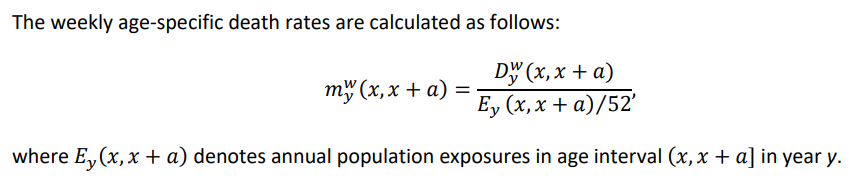

m stands for R in the formula below

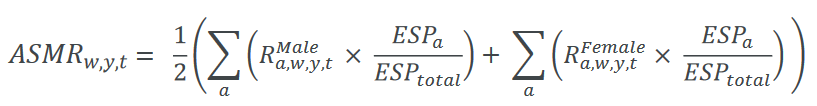

In [8]:
def weekly_ASMR(data, w, y, t):
    resM = np.zeros(len(age_cat))
    resF = np.zeros(len(age_cat))

    mask_M = (data['Sex'] == 'm') & (data['Year'] == y) & (data['Week'] == w)
    mask_F = (data['Sex'] == 'f') & (data['Year'] == y) & (data['Week'] == w)

    if not data[(data['Week'] == w) & (data['Year'] == y)].empty:
        for i, a in enumerate(age_cat):
            resM[i] = data[mask_M]['Death rates ' + a].iloc[0]*ESP[a]
            resF[i] = data[mask_F]['Death rates ' + a].iloc[0]*ESP[a]

        res = (np.sum(resM) + np.sum(resF)) /2 
        return res
    else:
        return None

In the working paper 180 written by the mortality projection committee of the Institute and Faculty of Actuaries, an adjustment is made for Sweden as "Eurostat notes that that there are deaths in the Sweden dataset that are assigned to a year but not assigned to a specific week. This affects around 3% of Swedish deaths on average." They compared the weekly deaths in the HMD STMF dataset to weekly deaths published by Statistics Sweden to assess the proportion of deaths not assigned to a specific week and made an approximate allowance for these deaths not assigned to a specific week. We used the same adjustments in our analysis. 

In [9]:
def death_rate_add_Sweden(y):
    res = 1
    if (y <= 2019) & (y>=2011):
        res = (88593+2056)/88593
    elif y == 2020:
        res = (94576+2663)/94576
    elif y == 2021:
        res = (88566+2951)/88566
    elif y == 2022:
        res = (90881+3605)/90881
    return res

In [10]:
def remplissage_weekly_ASMR(path_HMD_data, Country):
    
    data_weekly_ASMR = pd.DataFrame(columns=['Country', 'Year', 'Week', 'Date', 'Weekly ASMR'])
    
    for t in Country:
        data= pd.read_excel(path_HMD_data, sheet_name=Country_dic[t])
        #data = df[df['Country'] == Country_dic[t]]
        Year = list(range(2010, 2022+1))
        for y in Year:
            Week = list(range(1, 53+1))
            corr_w=0
            if n_week[y]==53:
                corr_w=1
            for w in Week:
                death_rate = weekly_ASMR(data,w, y, t)
                if (t == 'Sweden') & (death_rate != None): #adjust 
                    death_rate = death_rate*death_rate_add_Sweden(y)
                        
                date = datetime.strptime(f'{y}-W{w-corr_w}-1', '%Y-W%W-%w').date()
                new_row = {'Country': t, 'Year': y, 'Week': w, 'Date': date, 'Weekly ASMR': death_rate}
                data_weekly_ASMR = pd.concat([data_weekly_ASMR, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_weekly_ASMR  

In [11]:
data_weekly_ASMR = remplissage_weekly_ASMR(path_HMD_data, Country)
data_weekly_ASMR.to_excel(path_user + "weekly_ASMR_data.xlsx", index=False)

In [12]:
def monthly_ASMR_irelande(data, m, y):
    resM = np.zeros(len(age_cat))
    resF = np.zeros(len(age_cat))

    mask_M = (data['sex'] == 'm') & (data['year'] == y) & (data['month'] == m)
    mask_F = (data['sex'] == 'f') & (data['year'] == y) & (data['month'] == m)

    if not data[(data['month'] == m) & (data['year'] == y)].empty:
        for i, a in enumerate(age_cat):
            #print('Year:'+str(y)+' Month:'+str(m)+' age cat:'+str(a))
            resM[i] = data[mask_M & (data['age_cat']==a)]['death rate'].iloc[0]*ESP[a]
            resF[i] = data[mask_F & (data['age_cat']==a)]['death rate'].iloc[0]*ESP[a]

        res = (np.sum(resM) + np.sum(resF)) /2 
        return res
    else:
        return None

In [13]:
def remplissage_monthly_ASMR_ireland(path_ireland_data):
    
    data_monthly_ireland_ASMR = pd.DataFrame(columns=['Country', 'Year', 'Month', 'Date', 'Monthly ASMR'])
    
    data= pd.read_excel(path_ireland_data, sheet_name='data')
    Year = list(range(2010, 2022+1))
    for y in Year:
        for m in data['month'].unique():
            death_rate = monthly_ASMR_irelande(data,m, y)
                        
            date = datetime.strptime(f'{y}-{m}-28', '%Y-%B-%d').date()
            new_row = {'Country': 'Ireland', 'Year': y, 'Month': m, 'Date': date, 'Monthly ASMR': death_rate}
            data_monthly_ireland_ASMR = pd.concat([data_monthly_ireland_ASMR, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_monthly_ireland_ASMR  

In [14]:
data_monthly_ireland_ASMR = remplissage_monthly_ASMR_ireland(path_Ireland_data)
data_monthly_ireland_ASMR.to_excel(path_user + "monthly_ASMR_ireland_data.xlsx", index=False)

<h2 style="text-align: left; color: skyblue;">
    II-2) Weekly mortality rate without standardisation for age-statified excess mortality
</h2>

In [15]:
def remplissage_weekly_MR_not_standardised(path_HMD_data, Country):
    
    data_weekly_MR = pd.DataFrame(columns=['Country', 'Year', 'Week', 'Date', 'Age cat', 'Weekly ASMR'])
    
    for t in Country:
        data= pd.read_excel(path_HMD_data, sheet_name=Country_dic[t])
        #data = df[df['Country'] == Country_dic[t]]
        Year = list(range(2010, 2022+1))
        for y in Year:
            Week = list(range(1, 53+1))
            corr_w=0
            if n_week[y]==53:
                corr_w=1
            for a in age_cat_total:
                for w in Week:
                    death_rate_series = data[(data['Year']==y) & (data['Week']==w) & (data['Sex']=='b')]['Death rates '+ a]
                    if not death_rate_series.empty:
                        death_rate = death_rate_series.iloc[0]
                        if (t == 'Sweden') & (death_rate != None):
                            death_rate = death_rate*death_rate_add_Sweden(y)
                        
                        date = datetime.strptime(f'{y}-W{w-corr_w}-1', '%Y-W%W-%w').date()
                        new_row = {'Country': t, 'Year': y, 'Week': w, 'Date': date, 'Age cat': a, 'Weekly ASMR': death_rate}
                        data_weekly_MR = pd.concat([data_weekly_MR, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_weekly_MR  

In [16]:
def remplissage_monthly_MR_not_standardised_ireland(path_ireland_data):
    
    data_monthly_MR = pd.DataFrame(columns=['Country', 'Year', 'Month', 'Date', 'Age cat', 'Monthly ASMR'])

    data= pd.read_excel(path_ireland_data, sheet_name='data')
    Year = list(range(2010, 2022+1))
    for y in Year:
        Week = list(range(1, 53+1))
        for a in age_cat_total:
            for m in data['month'].unique():
                death_rate_series = data[(data['year']==y) & (data['month']==m) & (data['sex']=='b') & (data['age_cat']==a)]['death rate']
                if not death_rate_series.empty:
                    death_rate = death_rate_series.iloc[0]

                    date = datetime.strptime(f'{y}-{m}-28', '%Y-%B-%d').date()
                    new_row = {'Country': 'Ireland', 'Year': y, 'Month': m, 'Date': date, 'Age cat': a, 'Monthly ASMR': death_rate}
                    data_monthly_MR = pd.concat([data_monthly_MR, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_monthly_MR  

In [17]:
data_weekly_MR = remplissage_weekly_MR_not_standardised(path_HMD_data, Country)
data_weekly_MR.to_excel(path_user + "weekly_MR_data_not_standardised.xlsx", index=False)

data_monthly_MR_ireland = remplissage_monthly_MR_not_standardised_ireland(path_Ireland_data)
data_monthly_MR_ireland.to_excel(path_user + "monthly_MR_data_not_standardised_ireland.xlsx", index=False)

<h1 style="text-align: left; color: coral;">
    III- Annual ASMRs 
</h1>

Average of the annualised weekly ASMRs calculated above for the year

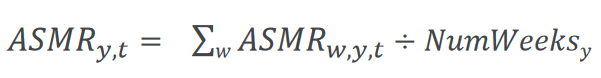

In [18]:
path_weekly_ASMR_data = path_user + "weekly_ASMR_data.xlsx"
path_weekly_MR_data = path_user + "weekly_MR_data_not_standardised.xlsx"
path_monthly_ireland_ASMR = path_user + "monthly_ASMR_ireland_data.xlsx"
path_monthly_MR_data_ireland = path_user + "monthly_MR_data_not_standardised_ireland.xlsx"


weekly_ASMR_data = pd.read_excel(path_weekly_ASMR_data)
weekly_MR_data = pd.read_excel(path_weekly_MR_data)
data_monthly_ireland_ASMR = pd.read_excel(path_monthly_ireland_ASMR)
data_monthly_ireland_MR = pd.read_excel(path_monthly_MR_data_ireland)

In [19]:
def annual_ASMR(data, data_ireland, y, t):
    if t=='Ireland':
        res=data_ireland[(data_ireland['Year']==y)]['Monthly ASMR'].sum()
        res = res / 12
    else:
        res=data[(data['Country']==t) & (data['Year']==y)]['Weekly ASMR'].sum()
        res = res / n_week[y]
    return res

In [20]:
def remplissage_annual_ASMR(data, data_ireland, Country):
    data_annual_ASMR = pd.DataFrame(columns=['Country', 'Year', 'Annual ASMR'])
    
    for t in Country:
        Year = list(range(2010, 2022+1))
        for y in Year:
            death_rate = annual_ASMR(data, data_ireland, y, t)
            new_row = {'Country': t, 'Year': y, 'Annual ASMR': death_rate}
            data_annual_ASMR = pd.concat([data_annual_ASMR, pd.DataFrame([new_row])], ignore_index=True)
    return data_annual_ASMR  

In [21]:
def remplissage_annual_MR_not_standardised(data, data_ireland, Country):
    data_annual_MR = pd.DataFrame(columns=['Country', 'Year', 'Age cat', 'Annual ASMR'])
    
    for t in Country:
        Year = list(range(2010, 2022+1))
        for y in Year:
            for a in age_cat_total :
                data_a = data[data['Age cat']==a]
                data_a_ireland = data_ireland[data_ireland['Age cat']==a]
                death_rate = annual_ASMR(data_a, data_a_ireland, y, t)
                new_row = {'Country': t, 'Year': y, 'Age cat':a, 'Annual ASMR': death_rate}
                data_annual_MR = pd.concat([data_annual_MR, pd.DataFrame([new_row])], ignore_index=True)
    return data_annual_MR 

In [22]:
data_annual_ASMR_ireland = remplissage_annual_ASMR(weekly_ASMR_data, data_monthly_ireland_ASMR, Country_ireland)
data_annual_MR_ireland = remplissage_annual_MR_not_standardised(weekly_MR_data, data_monthly_ireland_MR, Country_ireland)

data_annual_ASMR_ireland.to_excel(path_user + "data_annual_ASMR_ireland.xlsx", index=False)
data_annual_MR_ireland.to_excel(path_user + "data_annual_MR_ireland.xlsx", index=False)

<h1 style="text-align: left; color: coral;">
    IV- Weekly Expected mortality 
</h1>

Combination of two components :  
- An **annual mortality rate**: We calculate this for each territory by fitting a log-linear model to the annual ASMRs for 2010 to 2019 and then use the fitted value for 2019. For Italy where data is not available from 2010, we fit a log-linear model to the annual ASMRs from the earliest available full calendar year (2011) to 2019 and then use the fitted value for 2019.

- A **seasonality factor**: We calculate this for each territory based on average weekly and total mortality for that territory.

<h2 style="text-align: left; color: skyblue;">
    IV-1) Annual mortality rate
</h2>

We first find the values of 𝑎𝑡 and 𝑏𝑡 for each territory that minimises:

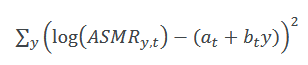

We then calculate the fitted value for 2020, 2021 and 2022

In [23]:
def ASMR_predicted(data_annual_ASMR, t, i, a=None):
    ymin = 2010
    if t == 'Italy':
        ymin = 2011 
    mask = (data_annual_ASMR['Year']>=ymin) & (data_annual_ASMR['Year']<=2019) & (data_annual_ASMR['Country']==t)
    if a !=None:
        mask=(data_annual_ASMR['Year']>=ymin) & (data_annual_ASMR['Year']<=2019) & (data_annual_ASMR['Country']==t) & (data_annual_ASMR['Age cat']==a)
    y = np.array(data_annual_ASMR[mask]['Year'])
    ASMR_y = np.array(data_annual_ASMR[mask]['Annual ASMR'])

    # Apply the natural logarithm to the dependent variable
    ASMR_y_log = np.log(ASMR_y)

    # Reshape the data to fit the model
    y = y.reshape(-1, 1)
    ASMR_y_log = ASMR_y_log.reshape(-1, 1)

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(y, ASMR_y_log)

    # Get the coefficients (slope and intercept)
    b_slope = model.coef_[0][0]
    a_intercept = model.intercept_[0]

    # Predict the values using the model
    y = np.array(data_annual_ASMR[(data_annual_ASMR['Year']>=ymin) &  (data_annual_ASMR['Year']<=2023) 
                              & (data_annual_ASMR['Country']==t)]['Year'])
    ASMR_y = np.array(data_annual_ASMR[(data_annual_ASMR['Year']>=ymin) &  (data_annual_ASMR['Year']<=2023) 
                              & (data_annual_ASMR['Country']==t)]['Annual ASMR'])
    y = y.reshape(-1, 1)
    ASMR_y_log = ASMR_y_log.reshape(-1, 1) 
    
    ASMR_y_pred_log = model.predict(y)
    ASMR_y_pred = np.exp(ASMR_y_pred_log)
    
    predicted_ASMR_2020 = np.exp(a_intercept + b_slope * 2020)
    predicted_ASMR_2021 = np.exp(a_intercept + b_slope * 2021)
    predicted_ASMR_2022 = np.exp(a_intercept + b_slope * 2022)

    return predicted_ASMR_2020,predicted_ASMR_2021,predicted_ASMR_2022

In [24]:
#dictionnairy to stock ASMR_fitted values
path_annual_ASMR_data_ireland = path_user + "data_annual_ASMR_ireland.xlsx"
path_annual_MR_data_ireland = path_user + "data_annual_MR_ireland.xlsx"

data_annual_ASMR_ireland = pd.read_excel(path_annual_ASMR_data_ireland)
data_annual_MR_ireland = pd.read_excel(path_annual_MR_data_ireland)


ASMR_fitted_2020 = {}
ASMR_fitted_2021 = {}
ASMR_fitted_2022 = {}
MR_fitted_2020 = {}
MR_fitted_2021 = {}
MR_fitted_2022 = {}


for i, t in enumerate(Country_ireland): 
    res20,res21,res22 = ASMR_predicted(data_annual_ASMR_ireland, t, i)
    ASMR_fitted_2020[t]=res20
    ASMR_fitted_2021[t]=res21
    ASMR_fitted_2022[t]=res22

    
for i, t in enumerate(Country_ireland) :
    MR_fitted_2020_a = {}
    MR_fitted_2021_a = {}
    MR_fitted_2022_a = {}
    
    for a in age_cat_total:
        res20,res21,res22 = ASMR_predicted(data_annual_MR_ireland, t, i, a)
        MR_fitted_2020_a[a]=res20
        MR_fitted_2021_a[a]=res21
        MR_fitted_2022_a[a]=res22
    MR_fitted_2020[t]=MR_fitted_2020_a
    MR_fitted_2021[t]=MR_fitted_2021_a
    MR_fitted_2022[t]=MR_fitted_2022_a

In [63]:
def ASMR_predicted_comparison(data_annual_ASMR1, data_annual_ASMR2, label1, label2, countries):
    num_countries = len(countries)
    num_rows = (num_countries + 2) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15,  3* num_rows+2))
    axs = axs.flatten() 

    for i, t in enumerate(countries):
        ymin = 2010
        if t == 'Italy':
            ymin = 2011
        mask10 = (data_annual_ASMR1['Year'] >= ymin) & (data_annual_ASMR1['Year'] <= 2019) & (data_annual_ASMR1['Country'] == t)
        mask10_CMI = (data_annual_ASMR2['Year'] >= ymin) & (data_annual_ASMR2['Year'] <= 2019) & (data_annual_ASMR2['Country'] == t)
        y = np.array(data_annual_ASMR1[mask10]['Year'])
        y_CMI= np.array(data_annual_ASMR2[mask10_CMI]['Year'])
        ASMR_y = np.array(data_annual_ASMR1[mask10]['Annual ASMR'])*1000
        ASMR_y_CMI = np.array(data_annual_ASMR2[mask10_CMI]['Annual ASMR'])*1000

        ASMR_y_log = np.log(ASMR_y)
        ASMR_y_log_CMI = np.log(ASMR_y_CMI)

        y = y.reshape(-1, 1)
        y_CMI = y_CMI.reshape(-1, 1)
        ASMR_y_log = ASMR_y_log.reshape(-1, 1)
        ASMR_y_log_CMI = ASMR_y_log_CMI.reshape(-1, 1)
        
        model = LinearRegression()
        model.fit(y, ASMR_y_log)
        
        model_CMI = LinearRegression()
        model_CMI.fit(y_CMI, ASMR_y_log_CMI)
        
        mask1 = (data_annual_ASMR1['Year'] >= ymin) & (data_annual_ASMR1['Year'] <= 2022) & (data_annual_ASMR1['Country'] == t)
        mask2 = (data_annual_ASMR2['Year'] >= ymin) & (data_annual_ASMR2['Year'] <= 2022) & (data_annual_ASMR2['Country'] == t)
        y = np.array(data_annual_ASMR1[mask1]['Year'])
        y_CMI= np.array(data_annual_ASMR2[mask2]['Year'])
        ASMR_y = np.array(data_annual_ASMR1[mask1]['Annual ASMR'])*1000
        ASMR_y_CMI = np.array(data_annual_ASMR2[mask2]['Annual ASMR'])*1000
        y = y.reshape(-1, 1)
        y_CMI = y_CMI.reshape(-1, 1)

        ASMR_y_pred_log = model.predict(y)
        ASMR_y_pred = np.exp(ASMR_y_pred_log)
        ASMR_y_pred_log_CMI = model_CMI.predict(y_CMI)
        ASMR_y_pred_CMI = np.exp(ASMR_y_pred_log_CMI)
        
        axs[i].scatter(y, ASMR_y, label=label1, color='blue')
        axs[i].scatter(y, ASMR_y_CMI, label=label2, color='Orange')
        axs[i].plot(y, ASMR_y_pred, label='Log-linear trend based on age- and sex-standardised rates from 2010 to 2019', color='blue')
        axs[i].plot(y, ASMR_y_pred_CMI, label='Log-linear trend based on non-standardised rates from 2010 to 2019', color='darkOrange')
        axs[i].set_xlabel('Year')
        axs[i].set_ylim(0,14)
        axs[i].set_ylabel('Mortality Rate \n(per 1000)', fontsize='large')
        axs[i].set_title(t, fontsize='x-large')
        #axs[i].legend()

    # Remove any empty subplots if the number of countries is not a multiple of 3
    for j in range(num_countries, num_rows * 3):
        fig.delaxes(axs[j])
    
    #plt.suptitle('Annual mortality rates and log-linear fitted mortality trend \ncomparison between age and sex standardised and not standardised data', fontsize='xx-large')
    plt.tight_layout(h_pad=0.3)
    leg = plt.legend(loc='lower center',bbox_to_anchor=(2.25, 0.2), ncol=1,fontsize='x-large',frameon=False)
    #plt.subplots_adjust(hspace=0.3)
    plt.show()

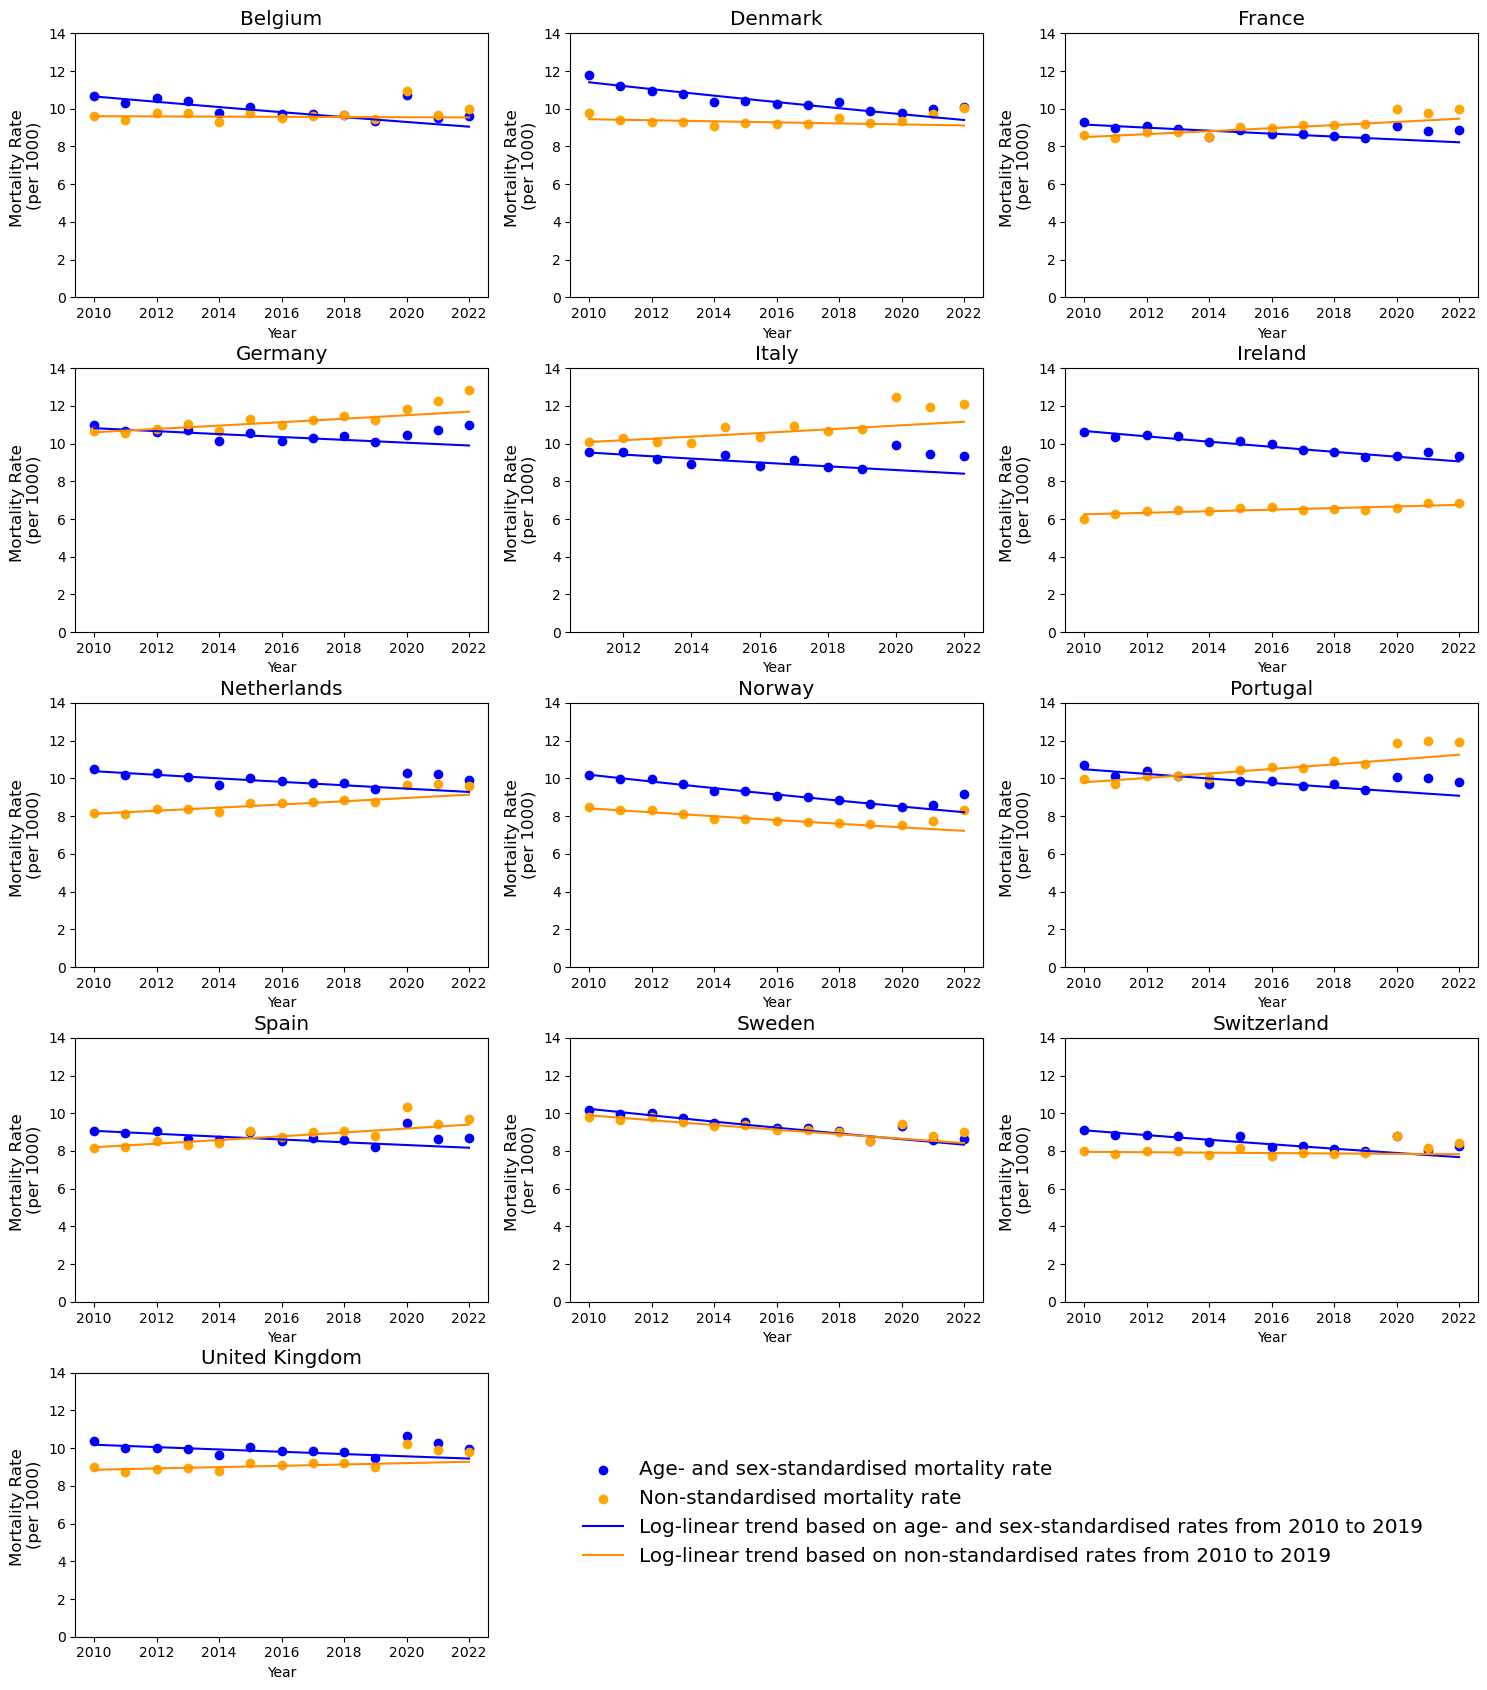

In [64]:
path_annual_ASMR_data = path_user + "data_annual_ASMR_ireland.xlsx"
path_annual_MR_data = path_user + "data_annual_MR_ireland.xlsx"

data_annual_ASMR = pd.read_excel(path_annual_ASMR_data)
data_annual_MR = pd.read_excel(path_annual_MR_data)

label1 = 'Age- and sex-standardised mortality rate'
label2 = 'Non-standardised mortality rate'
ASMR_predicted_comparison(data_annual_ASMR, data_annual_MR[data_annual_MR['Age cat']=='Total'], label1, label2, Country_ireland)

<h2 style="text-align: left; color: skyblue;">
    IV-2) Seasonality factor
</h2>

As mortality varies within each year due to seasonal effects, such as temperature and the typical peak influenza season, we have incorporated an allowance for seasonality in the expected ASMR measure. We calculate a seasonality factor 𝐹𝑤,𝑡 for each territory and week number (from 1 to 52) as:

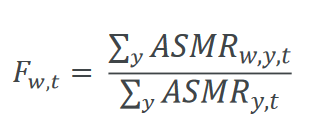

In [29]:
def F(data_weekly_ASMR, data_annual_ASMR, w, t, a=None):
    ymin = 2010
    if t == 'Italy':
        ymin = 2011
    
    maskw = (data_weekly_ASMR['Country'] == t) & (data_weekly_ASMR['Week'] == w)
    masky = (data_annual_ASMR['Country'] == t)

    if a is not None:
        maskw &= (data_weekly_ASMR['Age cat'] == a)
        masky &= (data_annual_ASMR['Age cat'] == a)

    res1 = np.nansum(data_weekly_ASMR[maskw & (data_weekly_ASMR['Year'] >= ymin) & (data_weekly_ASMR['Year'] <= 2019)]['Weekly ASMR'])
    res2 = np.nansum(data_annual_ASMR[masky & (data_annual_ASMR['Year'] >= ymin) & (data_annual_ASMR['Year'] <= 2019)]['Annual ASMR'])

    if res2 != 0:
        res = np.divide(res1, res2, dtype=np.float64)
        return round(res, 2)
    else:
        return None

In [30]:
#Dictionnary to stock seasonnality factors values 
Week = list(range(1, 52+1))
Fwt = {}
Fwt_not_standardised = {}

for t in Country :
    Fw = {}
    for w in Week : 
        Fw[w] = F(weekly_ASMR_data, data_annual_ASMR, w, t)
    Fw[53]=Fw[52]
    Fwt[t]=Fw
    
    
for t in Country :
    Fa = {}
    for a in age_cat_total:
        Fw={}
        for w in Week : 
            Fw[w] = F(weekly_MR_data, data_annual_MR, w, t, a)
        Fw[53]=Fw[52]
        Fa[a]=Fw
    Fwt_not_standardised[t]=Fa
    

In [31]:
def F_ireland(data_monthly_ireland_ASMR, data_annual_ASMR_ireland, m, a=None):
    ymin = 2010
    
    maskm = (data_monthly_ireland_ASMR['Month'] == m)
    masky = (data_annual_ASMR_ireland['Country'] == 'Ireland')

    if a is not None:
        maskm &= (data_monthly_ireland_ASMR['Age cat'] == a)
        masky &= (data_annual_ASMR_ireland['Age cat'] == a)

    res1 = np.nansum(data_monthly_ireland_ASMR[maskm & (data_monthly_ireland_ASMR['Year'] >= ymin) & (data_monthly_ireland_ASMR['Year'] <= 2019)]['Monthly ASMR'])
    res2 = np.nansum(data_annual_ASMR_ireland[masky & (data_annual_ASMR_ireland['Year'] >= ymin) & (data_annual_ASMR_ireland['Year'] <= 2019)]['Annual ASMR'])

    if res2 != 0:
        res = np.divide(res1, res2, dtype=np.float64)
        return round(res, 2)
    else:
        return None

In [32]:
#Dictionnary to stock seasonnality factors values 
Month = ['January','February','March','April','May','June','July','August','September','October','November','December']

Fm_ireland = {}
for m in Month : 
    Fm_ireland[m] = F_ireland(data_monthly_ireland_ASMR, data_annual_ASMR_ireland, m)
    
Fma_ireland = {}    
for a in age_cat_total:
    Fm={}
    for m in Month : 
        Fm[m] = F_ireland(data_monthly_ireland_MR, data_annual_MR_ireland, m, a)
        Fma_ireland[a]=Fm

<h2 style="text-align: left; color: skyblue;">
    IV-3) Weekly expected mortality v2020-2021-2022
</h2>

We multiply the two components (annual fitted mortality rate and seasonality factor) to calculate weekly expected mortality rates for 2020, 2021 and 2022

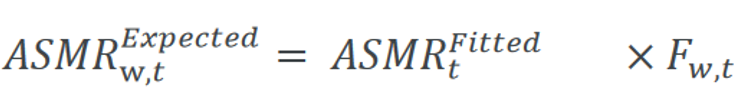

In [33]:
Week = list(range(1, 53+1))
ASMR_expected_wt_20 = {}
ASMR_expected_wt_21 = {}
ASMR_expected_wt_22 = {}
MR_expected_wat_20 = {}
MR_expected_wat_21 = {}
MR_expected_wat_22 = {}

for t in Country :
    ASMR_expected_w_20 = {}
    ASMR_expected_w_21 = {}
    ASMR_expected_w_22 = {}

    for w in Week : 
        ASMR_expected_w_20[w] = ASMR_fitted_2020[t] * Fwt[t][w]
        ASMR_expected_w_21[w] = ASMR_fitted_2021[t] * Fwt[t][w]
        ASMR_expected_w_22[w] = ASMR_fitted_2022[t] * Fwt[t][w]
    ASMR_expected_wt_20[t]=ASMR_expected_w_20
    ASMR_expected_wt_21[t]=ASMR_expected_w_21
    ASMR_expected_wt_22[t]=ASMR_expected_w_22
    

    
for t in Country :
    MR_expected_wa_20 = {}
    MR_expected_wa_21 = {}
    MR_expected_wa_22 = {}
    for a in age_cat_total:
        MR_expected_w_20={}
        MR_expected_w_21={}
        MR_expected_w_22={}
        for w in Week : 
            MR_expected_w_20[w] = MR_fitted_2020[t][a] * Fwt_not_standardised[t][a][w]
            MR_expected_w_21[w] = MR_fitted_2021[t][a] * Fwt_not_standardised[t][a][w]
            MR_expected_w_22[w] = MR_fitted_2022[t][a] * Fwt_not_standardised[t][a][w]
        MR_expected_wa_20[a]=MR_expected_w_20
        MR_expected_wa_21[a]=MR_expected_w_21
        MR_expected_wa_22[a]=MR_expected_w_22
    MR_expected_wat_20[t]=MR_expected_wa_20
    MR_expected_wat_21[t]=MR_expected_wa_21
    MR_expected_wat_22[t]=MR_expected_wa_22 

In [34]:
Month = ['January','February','March','April','May','June','July','August','September','October','November','December']
ASMR_expected_m_20_ireland = {}
ASMR_expected_m_21_ireland = {}
ASMR_expected_m_22_ireland = {}

for m in Month: 
    ASMR_expected_m_20_ireland[m] = ASMR_fitted_2020['Ireland'] * Fm_ireland[m]
    ASMR_expected_m_21_ireland[m] = ASMR_fitted_2021['Ireland'] * Fm_ireland[m]
    ASMR_expected_m_22_ireland[m] = ASMR_fitted_2022['Ireland'] * Fm_ireland[m]

    
MR_expected_ma_20_ireland = {}
MR_expected_ma_21_ireland = {}
MR_expected_ma_22_ireland = {}
for a in age_cat_total:
    MR_expected_m_20={}
    MR_expected_m_21={}
    MR_expected_m_22={}
    for m in Month: 
        MR_expected_m_20[m] = MR_fitted_2020['Ireland'][a] * Fma_ireland[a][m]
        MR_expected_m_21[m] = MR_fitted_2021['Ireland'][a] * Fma_ireland[a][m]
        MR_expected_m_22[m] = MR_fitted_2022['Ireland'][a] * Fma_ireland[a][m]
    MR_expected_ma_20_ireland[a]=MR_expected_m_20
    MR_expected_ma_21_ireland[a]=MR_expected_m_21
    MR_expected_ma_22_ireland[a]=MR_expected_m_22

<h1 style="text-align: left; color: coral;">
    V- Relative excess mortality
</h1>

For each week and territory as the percentage difference between the actual ASMR and expected mortality.

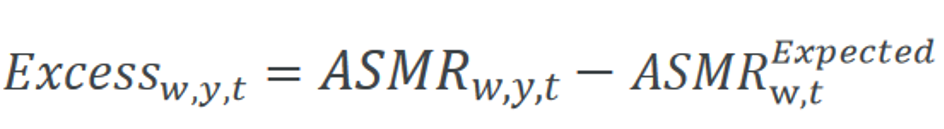

In [35]:
def Excess_diff(data_weekly_ASMR, ASMR_expected_wt ,w,y,t,a=None):
    mask=(data_weekly_ASMR['Week']==w) & (data_weekly_ASMR['Year']==y) & (data_weekly_ASMR['Country']==t)
    if a!=None:
        mask &=  (data_weekly_ASMR['Age cat']==a)
    
    filtered_data = data_weekly_ASMR[mask]
    if not filtered_data.empty:
        ASMRwyt = filtered_data['Weekly ASMR'].iloc[0]
        
        if a ==None:
            ASMR_expectedwt = ASMR_expected_wt[t][w]
        else:
            ASMR_expectedwt = ASMR_expected_wt[t][a][w]
            
        res = ASMRwyt-ASMR_expectedwt
        return res
    else :
        return None

In [36]:
def remplissage_excess_v20_21_22(data_weekly_ASMR, ASMR_expected_wt_20, ASMR_expected_wt_21, ASMR_expected_wt_22, Country, method_excess):
    data_excess = pd.DataFrame(columns=['Country', 'Year', 'Week', 'Date', 'Excess'])
    
    for t in Country:
        Year = list(range(2020, 2022+1))
        for y in Year:
            Week = list(range(1, n_week[y]+1))
            corr_w=0
            if n_week[y]==53:
                corr_w=1
            for w in Week:
                date = datetime.strptime(f'{y}-W{w-corr_w}-1', '%Y-W%W-%w').date()
                if y==2020:
                    Excesswyt = method_excess(data_weekly_ASMR, ASMR_expected_wt_20, w, y, t)
                elif y==2021:
                    Excesswyt = method_excess(data_weekly_ASMR, ASMR_expected_wt_21, w, y, t)
                elif y==2022:
                    Excesswyt = method_excess(data_weekly_ASMR, ASMR_expected_wt_22, w, y, t)
                    
                new_row = {'Country': t, 'Year': y, 'Week': w, 'Date': date, 'Excess': Excesswyt}
                data_excess = pd.concat([data_excess, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_excess 

In [37]:
def remplissage_excess_v20_21_22_not_standardised(data_weekly_MR, MR_expected_wat_20, MR_expected_wat_21, MR_expected_wat_22, Country, methode_excess):
    data_excess = pd.DataFrame(columns=['Country', 'Year', 'Week', 'Date', 'Age cat', 'Excess'])
    
    for t in Country:
        Year = list(range(2020, 2022+1))
        for a in age_cat_total : 
            for y in Year:
                Week = list(range(1, n_week[y]+1))
                corr_w=0
                if n_week[y]==53:
                    corr_w=1
                for w in Week:
                    date = datetime.strptime(f'{y}-W{w-corr_w}-1', '%Y-W%W-%w').date()
                    if y==2020:
                        Excesswyt = methode_excess(data_weekly_MR,MR_expected_wat_20,w, y, t, a)
                    elif y==2021:
                        Excesswyt = methode_excess(data_weekly_MR,MR_expected_wat_21,w, y, t, a)
                    elif y==2022:
                        Excesswyt = methode_excess(data_weekly_MR,MR_expected_wat_22,w, y, t, a)
                    
                    new_row = {'Country': t, 'Year': y, 'Week': w, 'Date': date, 'Age cat':a, 'Excess': Excesswyt}
                    data_excess = pd.concat([data_excess, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_excess  

In [38]:
data_excess_v20_21_22_diff = remplissage_excess_v20_21_22(weekly_ASMR_data, ASMR_expected_wt_20, ASMR_expected_wt_21, ASMR_expected_wt_22, Country, Excess_diff)
data_excess_v20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)

data_excess_v20_21_22_not_standardised_diff = remplissage_excess_v20_21_22_not_standardised(weekly_MR_data, MR_expected_wat_20, MR_expected_wat_21, MR_expected_wat_22, Country, Excess_diff)
data_excess_v20_21_22_not_standardised_diff.to_excel(path_user + "Excess_data_20_21_22_not_standardised_diff.xlsx", index=False)

In [39]:
def Excess_diff_ireland(data_monthly_ireland_ASMR, ASMR_expected_m_ireland ,m,y,a=None):
    mask=(data_monthly_ireland_ASMR['Month']==m) & (data_monthly_ireland_ASMR['Year']==y)
    if a!=None:
        mask &=  (data_monthly_ireland_ASMR['Age cat']==a)
    
    filtered_data = data_monthly_ireland_ASMR[mask]
    if not filtered_data.empty:
        ASMRmy = filtered_data['Monthly ASMR'].iloc[0]
        
        if a ==None:
            ASMR_expectedm = ASMR_expected_m_ireland[m]
        else:
            ASMR_expectedm = ASMR_expected_m_ireland[a][m]
            
        res = ASMRmy-ASMR_expectedm
        return res
    else :
        return None

In [40]:
def remplissage_excess_v20_21_22_ireland(data_monthly_ireland_ASMR, ASMR_expected_m_20_ireland, ASMR_expected_m_21_ireland, ASMR_expected_m_22_ireland, method_excess):
    data_excess = pd.DataFrame(columns=['Country', 'Year', 'Month', 'Date', 'Excess'])
    
    Year = list(range(2020, 2022+1))
    for y in Year:
        Month = ['January','February','March','April','May','June','July','August','September','October','November','December']
        for m in Month:
            date = datetime.strptime(f'{y}-{m}-28', '%Y-%B-%d').date()
            if y==2020:
                Excessmy = method_excess(data_monthly_ireland_ASMR, ASMR_expected_m_20_ireland, m, y)
            elif y==2021:
                Excessmy = method_excess(data_monthly_ireland_ASMR, ASMR_expected_m_21_ireland, m, y)
            elif y==2022:
                Excessmy = method_excess(data_monthly_ireland_ASMR, ASMR_expected_m_22_ireland, m, y)

            new_row = {'Country': 'Ireland', 'Year': y, 'Month': m, 'Date': date, 'Excess': Excessmy}
            data_excess = pd.concat([data_excess, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_excess 

In [41]:
def remplissage_excess_v20_21_22_not_standardised_ireland(data_monthly_MR_ireland, MR_expected_ma_20_ireland, MR_expected_ma_21_ireland, MR_expected_ma_22_ireland, methode_excess):
    data_excess = pd.DataFrame(columns=['Country', 'Year', 'Month', 'Date', 'Age cat', 'Excess'])
    
    Year = list(range(2020, 2022+1))
    for a in age_cat_total : 
        for y in Year:
            Month = ['January','February','March','April','May','June','July','August','September','October','November','December']
            for m in Month:
                date = datetime.strptime(f'{y}-{m}-28', '%Y-%B-%d').date()
                if y==2020:
                    Excessmy = methode_excess(data_monthly_MR_ireland,MR_expected_ma_20_ireland,m, y, a)
                elif y==2021:
                    Excessmy = methode_excess(data_monthly_MR_ireland,MR_expected_ma_21_ireland,m, y, a)
                elif y==2022:
                    Excessmy = methode_excess(data_monthly_MR_ireland,MR_expected_ma_22_ireland,m, y, a)

                new_row = {'Country': 'Ireland', 'Year': y, 'Month': m, 'Date': date, 'Age cat':a, 'Excess': Excessmy}
                data_excess = pd.concat([data_excess, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_excess  

In [42]:
data_excess_v20_21_22_diff_ireland = remplissage_excess_v20_21_22_ireland(data_monthly_ireland_ASMR, ASMR_expected_m_20_ireland, ASMR_expected_m_21_ireland, ASMR_expected_m_22_ireland, Excess_diff_ireland)
data_excess_v20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)

data_excess_v20_21_22_not_standardised_diff_ireland = remplissage_excess_v20_21_22_not_standardised_ireland(data_monthly_ireland_MR, MR_expected_ma_20_ireland, MR_expected_ma_22_ireland, MR_expected_ma_22_ireland, Excess_diff_ireland)
data_excess_v20_21_22_not_standardised_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_not_standardised_diff_ireland.xlsx", index=False)

<h1 style="text-align: left; color: coral;">
    VI- Cumulative relative excess mortality 
</h1>

As the accumulation of relative excess mortality over time.

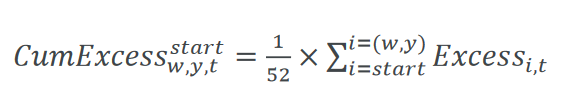

By hand on Excel from w5-2020 to w26-2022
ie from Date = 03/02/2020 to Date = 27/06/2022

In [43]:
def remplissage_cummulative(data_excess, date_debut, date_fin, methode_excess, colname):
    data_excess_copy = data_excess.copy()

    data_excess_copy['Date'] = pd.to_datetime(data_excess_copy['Date'])
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)

    data_excess_copy[colname] = pd.Series(dtype=float)

    for t in data_excess_copy['Country'].unique():
        mask = (data_excess_copy['Country'] == t) & (data_excess_copy['Date'] >= date_debut) & (data_excess_copy['Date'] <= date_fin)
        selected_data = data_excess_copy.loc[mask]

        excess_cum = 0
        for index, row in selected_data.iterrows():
            excess_cum += row['Excess']
            data_excess_copy.at[index, colname] = excess_cum
            if row['Year']=='2020':
                data_excess_copy.at[index, colname] /= 52
            else:
                data_excess_copy.at[index, colname] /= 52

    return data_excess_copy

In [44]:
def remplissage_cummulative_ireland(data_excess_ireland, date_debut, date_fin, colname):
    data_excess_copy = data_excess_ireland.copy()

    data_excess_copy['Date'] = pd.to_datetime(data_excess_copy['Date'])
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)

    data_excess_copy[colname] = pd.Series(dtype=float)

    mask = (data_excess_copy['Date'] >= date_debut) & (data_excess_copy['Date'] <= date_fin)
    selected_data = data_excess_copy.loc[mask]

    excess_cum = 0
    for index, row in selected_data.iterrows():
        excess_cum += row['Excess']
        data_excess_copy.at[index, colname] = excess_cum
        data_excess_copy.at[index, colname] /= 12

    return data_excess_copy

In [45]:
def remplissage_cummulative_stratifie(data_excess, date_debut, date_fin, methode_excess, colname):
    data_excess_copy = data_excess.copy()

    data_excess_copy['Date'] = pd.to_datetime(data_excess_copy['Date'])
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)

    data_excess_copy[colname] = pd.Series(dtype=float)

    for t in data_excess_copy['Country'].unique():
        for a in data_excess_copy['Age cat'].unique():
            mask = (data_excess_copy['Country'] == t) & (data_excess_copy['Age cat'] == a) & (data_excess_copy['Date'] >= date_debut) & (data_excess_copy['Date'] <= date_fin)
            selected_data = data_excess_copy.loc[mask]

            excess_cum = 0
            for index, row in selected_data.iterrows():
                excess_cum += row['Excess']
                data_excess_copy.at[index, colname] = excess_cum

                if row['Year']=='2020':
                    data_excess_copy.at[index, colname] /= 52
                else:
                    data_excess_copy.at[index, colname] /= 52

    return data_excess_copy

In [46]:
def remplissage_cummulative_stratifie_ireland(data_excess_ireland, date_debut, date_fin, colname):
    data_excess_copy = data_excess_ireland.copy()

    data_excess_copy['Date'] = pd.to_datetime(data_excess_copy['Date'])
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)

    data_excess_copy[colname] = pd.Series(dtype=float)

    for a in data_excess_copy['Age cat'].unique():
        mask = (data_excess_copy['Age cat'] == a) & (data_excess_copy['Date'] >= date_debut) & (data_excess_copy['Date'] <= date_fin)
        selected_data = data_excess_copy.loc[mask]

        excess_cum = 0
        for index, row in selected_data.iterrows():
            excess_cum += row['Excess']
            data_excess_copy.at[index, colname] = excess_cum
            data_excess_copy.at[index, colname] /= 12

    return data_excess_copy

In [47]:
date_debut = datetime.strptime("27/01/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("03/07/2022", "%d/%m/%Y").date()

colname = 'Cumulative Excess From w5y2020 to w26y2022'

data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff, colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)

data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_not_standardised_diff.xlsx")
data_excess_20_21_22_strat_diff = remplissage_cummulative_stratifie(data_excess, date_debut, date_fin, Excess_diff, colname)
data_excess_20_21_22_strat_diff.to_excel(path_user + "Excess_data_20_21_22_not_standardised_diff.xlsx", index=False)


date_debut = datetime.strptime("28/02/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2022", "%d/%m/%Y").date()

data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)

data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_not_standardised_diff_ireland.xlsx")
data_excess_20_21_22_strat_diff_ireland = remplissage_cummulative_stratifie_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_strat_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_not_standardised_diff_ireland.xlsx", index=False)

In [48]:
#Global Periode 
colname = 'Cumulative Excess From 27/01/2020 to 03/07/2022'
 
date_debut = datetime.strptime("27/01/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("03/07/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("28/02/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)


#Periode 1 et hosp 1 et trust in gov 2019
colname = 'Cumulative Excess From 27/01/2020 to 28/06/2020'
 
date_debut = datetime.strptime("27/01/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2020", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("28/02/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2020", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)


#Periode 2 et trust in gov 2020
colname = 'Cumulative Excess From 29/06/2020 to 27/06/2021'
 
date_debut = datetime.strptime("29/06/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("27/06/2021", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("28/07/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2021", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)
 

#Periode 3
colname = 'Cumulative Excess From 28/06/2021 to 03/07/2022'
 
date_debut = datetime.strptime("28/06/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("03/07/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("28/07/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)
 

#### hosp 2 
colname = 'Cumulative Excess From 28/09/2020 to 27/12/2020'
date_debut = datetime.strptime("28/09/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("27/12/2020", "%d/%m/%Y").date()
 
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("28/09/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/12/2020", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)
 

#### Vaccins first dose
colname = 'Cumulative Excess From 01/03/2021 to 27/06/2021'
 
date_debut = datetime.strptime("01/03/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("27/06/2021", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("01/03/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/06/2021", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)
 

#### Vaccin first booster
#colname = 'Cumulative Excess From 01/11/2021 to 26/06/2022'
colname = 'Cumulative Excess From 04/10/2021 to 30/01/2022'
 
date_debut = datetime.strptime("04/10/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("30/01/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("01/10/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/01/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)
 

#### international arrival 2020
colname = 'Cumulative Excess From 27/01/2020 to 03/01/2021'
 
date_debut = datetime.strptime("27/01/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("03/01/2021", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("28/02/2020", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/12/2020", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)
 

#### International arrival 2021
colname = 'Cumulative Excess From 04/01/2021 to 02/01/2022'
 
date_debut = datetime.strptime("04/01/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("02/01/2022", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_diff = remplissage_cummulative(data_excess, date_debut, date_fin, Excess_diff,colname)
data_excess_20_21_22_diff.to_excel(path_user + "Excess_data_20_21_22_diff.xlsx", index=False)
 
date_debut = datetime.strptime("04/01/2021", "%d/%m/%Y").date()
date_fin = datetime.strptime("28/12/2021", "%d/%m/%Y").date()
data_excess = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_diff_ireland = remplissage_cummulative_ireland(data_excess, date_debut, date_fin, colname)
data_excess_20_21_22_diff_ireland.to_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx", index=False)

<h1 style="text-align: left; color: coral;">
    VII- Cumulative relative excess mortality 
</h1>

<h2 style="text-align: left; color: skyblue;">
    VII-1) Global curves
</h2>

In [49]:
couleurs_pays = {
    'Belgium': '#C0CA33',
    'Denmark': '#33B5E5',
    'France': '#3F51B5',
    'Germany': '#90A4AE',
    'Ireland': '#26A69A',
    'Italy': '#1B5E20',
    'Netherlands': '#4CAF50',
    'Norway': '#8E24AA',  
    'Portugal': '#FDD835',
    'Spain': '#FF4081',
    'Sweden': '#1976D2',  
    'Switzerland': '#F00020',  
    'United Kingdom': '#FF9800',
    'England + Wales': '#FF9800'
}

In [50]:
data_excess_20_21_22_diff = pd.read_excel(path_user + "Excess_data_20_21_22_diff.xlsx")
data_excess_20_21_22_not_standardised_diff = pd.read_excel(path_user + "Excess_data_20_21_22_not_standardised_diff.xlsx")
data_excess_20_21_22_diff_ireland = pd.read_excel(path_user + "Excess_data_20_21_22_diff_ireland.xlsx")
data_excess_20_21_22_not_standardised_diff_ireland = pd.read_excel(path_user + "Excess_data_20_21_22_not_standardised_diff_ireland.xlsx")

date_debut = pd.to_datetime(datetime.strptime("03/02/2020", "%d/%m/%Y").date())
date_fin = pd.to_datetime(datetime.strptime("27/06/2022", "%d/%m/%Y").date())

data_excess_20_21_22_diff['Date']=pd.to_datetime(data_excess_20_21_22_diff['Date'])
data_excess_20_21_22_not_standardised_diff['Date']=pd.to_datetime(data_excess_20_21_22_not_standardised_diff['Date'])
data_excess_20_21_22_diff_ireland['Date']=pd.to_datetime(data_excess_20_21_22_diff_ireland['Date'])
data_excess_20_21_22_not_standardised_diff_ireland['Date']=pd.to_datetime(data_excess_20_21_22_not_standardised_diff_ireland['Date'])

data_excess_20_21_22_diff = data_excess_20_21_22_diff[(data_excess_20_21_22_diff['Date'] >= date_debut) & (data_excess_20_21_22_diff['Date'] <= date_fin)]
data_excess_20_21_22_not_standardised_diff = data_excess_20_21_22_not_standardised_diff[(data_excess_20_21_22_not_standardised_diff['Date'] >= date_debut) 
                                                                                        & (data_excess_20_21_22_not_standardised_diff['Date'] <= date_fin)]


In [51]:
def plot_df_diff(ax, data_excess, data_excess_ireland, colname, title, d_beg, d_end, dic_position):
    # Courbe pour chaque pays
    data_excess = data_excess[data_excess['Country'] != 'England + Wales']
    for location, group in data_excess.groupby('Country'):
        #combined_x = [str(year) + ' w' + str(week) for year, week in zip(group['Year'], group['Week'])]
        ax.plot(group['Date'], group[colname]*1000, label=location, color=couleurs_pays[location])
    ax.plot(data_excess_ireland['Date'],data_excess_ireland[colname]*1000, label='Ireland',color=couleurs_pays['Ireland'] )

    # Ajouter des étiquettes à la fin des courbes
    for location, group in data_excess.groupby('Country'):
        #x_end = combined_x[-1]
        x_end =group[group[colname].notna()]['Date'].iloc[-1]
        y_end = group[group[colname].notna()][colname].iloc[-1]*1000
        # Ajuster les étiquettes
        x_text = x_end + pd.DateOffset(days=3)
        y_text = y_end + dic_position[location]
        if location!='United Kingdom':
            #ax.annotate(location+'_'+CMI, xy=(x_end, y_end), xytext=(x_text, y_text), fontsize='small')
            ax.annotate(location, xy=(x_end, y_end), xytext=(x_text, y_text), fontsize='small')

        else :
            ax.annotate('UK', xy=(x_end, y_end), xytext=(x_text, y_text), fontsize='small')
            
    ax.annotate('Ireland',xy=(data_excess_ireland[data_excess_ireland[colname].notna()]['Date'].iloc[-1], data_excess_ireland[data_excess_ireland[colname].notna()][colname].iloc[-1]*1000), xytext=(data_excess_ireland[data_excess_ireland[colname].notna()]['Date'].iloc[-1]+pd.DateOffset(days=3), data_excess_ireland[data_excess_ireland[colname].notna()][colname].iloc[-1]*1000 + dic_position['Ireland']), fontsize='small')
    
    # Boîte et grille
    #ax.set_xlim(-1, 1.16*len(combined_x))
    ax.set_xlim(group[group[colname].notna()]['Date'].min() - pd.DateOffset(days=d_beg), group[group[colname].notna()]['Date'].max() + pd.DateOffset(days=d_end))
    #ax.set_ylim(-0.5,3)
    ax.grid(axis='y', linestyle='--')
    ax.set_title(title,fontsize='x-large')
    #ax.set_xlabel('Date',fontsize='large')
    #x_labels = [label for label in combined_x if label.endswith('0')]
    #ax.set_xticks(x_labels)
    ax.set_ylabel('Cumulative excess mortality (per 1000)',fontsize='x-large')
    ax.tick_params(axis='both', which='both', labelsize='large')
    ax.tick_params(axis='x', which='both',rotation=45)

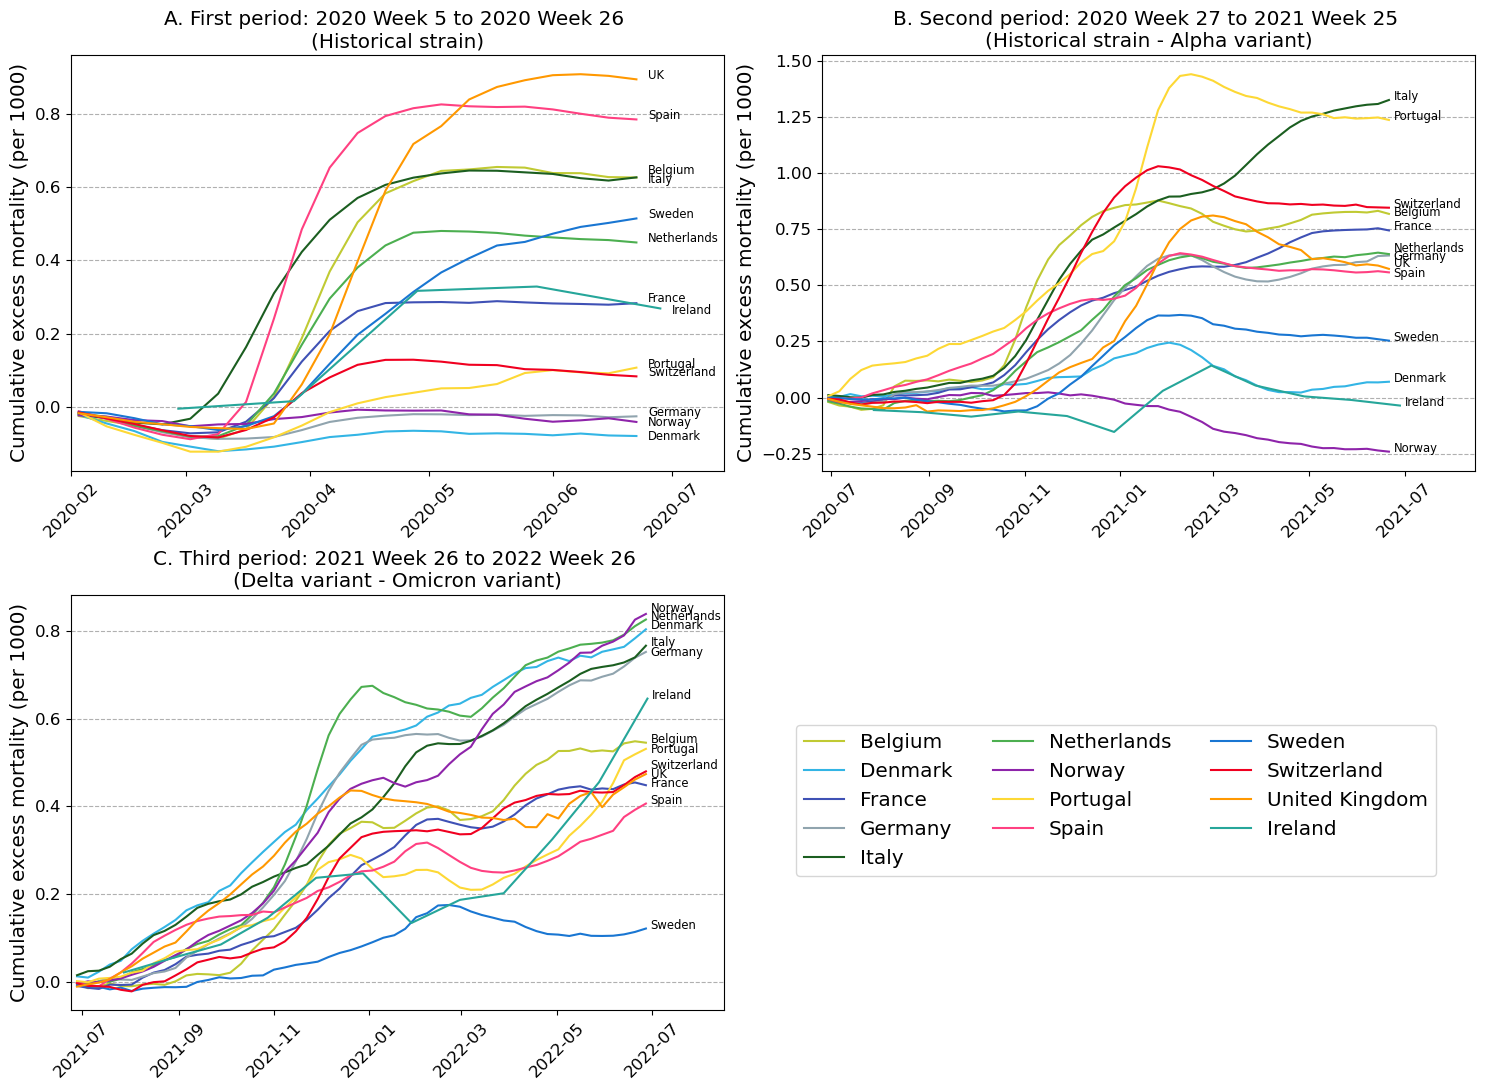

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
col2 = 'Cumulative Excess From 27/01/2020 to 28/06/2020'
col3 = 'Cumulative Excess From 29/06/2020 to 27/06/2021'
col4 = 'Cumulative Excess From 28/06/2021 to 03/07/2022'
title_2 = 'A. First period: 2020 Week 5 to 2020 Week 26 \n(Historical strain)'
title_3 = 'B. Second period: 2020 Week 27 to 2021 Week 25 \n(Historical strain - Alpha variant)'
title_4 = 'C. Third period: 2021 Week 26 to 2022 Week 26 \n(Delta variant - Omicron variant)'

dic_position={'Belgium':0.01, 'Denmark':-0.01, 'France':0.003, 'Germany':0, 'Ireland':-0.015, 'Italy':-0.015, 'Netherlands':0, 'Norway':-0.01, 'Portugal':0, 'Spain':0, 'Sweden':0, 'Switzerland':0, 'United Kingdom':0, 'England':0}
plot_df_diff(axs[0,0], data_excess_20_21_22_diff, data_excess_20_21_22_diff_ireland, colname=col2, title=title_2, d_beg=2, d_end=22, dic_position=dic_position)

dic_position={'Belgium':-0.01, 'Denmark':0, 'France':0, 'Germany':-0.02, 'Ireland':0, 'Italy':0, 'Netherlands':0.01, 'Norway':0, 'Portugal':0, 'Spain':-0.02, 'Sweden':0, 'Switzerland':0, 'United Kingdom':0.01, 'England':0}
plot_df_diff(axs[0,1], data_excess_20_21_22_diff, data_excess_20_21_22_diff_ireland, colname=col3, title=title_3, d_beg=4, d_end=55, dic_position=dic_position)

dic_position={'Belgium':0, 'Denmark':0, 'France':-0.005, 'Germany':-0.01, 'Ireland':0, 'Italy':0, 'Netherlands':0, 'Norway':0.005, 'Portugal':-0.01, 'Spain':0, 'Sweden':0, 'Switzerland':0.005, 'United Kingdom':-0.01, 'England':0}
plot_df_diff(axs[1,0], data_excess_20_21_22_diff, data_excess_20_21_22_diff_ireland, colname=col4, title=title_4, d_beg=4, d_end=50, dic_position=dic_position)

fig.delaxes(axs[1,1])

#plt.suptitle('Fig.1',fontsize='xx-large')
plt.tight_layout()
leg = plt.legend(loc='lower center',bbox_to_anchor=(1.6, 0.3), ncol=3,fontsize='x-large',frameon=True)
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

<h2 style="text-align: left; color: skyblue;">
    VII-2) Stratified curves
</h2>

In [55]:
data_excess_20_21_22_not_standardised_diff = pd.read_excel(path_user + "Excess_data_20_21_22_not_standardised_diff.xlsx")
data_excess_20_21_22_not_standardised_diff_ireland = pd.read_excel(path_user + "Excess_data_20_21_22_not_standardised_diff_ireland.xlsx")

date_debut = pd.to_datetime(datetime.strptime("03/02/2020", "%d/%m/%Y").date())
date_fin = pd.to_datetime(datetime.strptime("27/06/2022", "%d/%m/%Y").date())
date_debut_ireland = pd.to_datetime(datetime.strptime("01/02/2020", "%d/%m/%Y").date())
date_fin_ireland = pd.to_datetime(datetime.strptime("01/07/2022", "%d/%m/%Y").date())
data_excess_20_21_22_not_standardised_diff['Date']=pd.to_datetime(data_excess_20_21_22_not_standardised_diff['Date'])
data_excess_20_21_22_not_standardised_diff_ireland['Date']=pd.to_datetime(data_excess_20_21_22_not_standardised_diff_ireland['Date'])

data_excess_20_21_22_not_standardised_diff = data_excess_20_21_22_not_standardised_diff[(data_excess_20_21_22_not_standardised_diff['Date'] >= date_debut) 
                                                                                        & (data_excess_20_21_22_not_standardised_diff['Date'] <= date_fin)]

data_excess_20_21_22_not_standardised_diff_ireland = data_excess_20_21_22_not_standardised_diff_ireland[(data_excess_20_21_22_not_standardised_diff_ireland['Date'] >= date_debut_ireland) 
                                                                                        & (data_excess_20_21_22_not_standardised_diff_ireland['Date'] <= date_fin_ireland)]

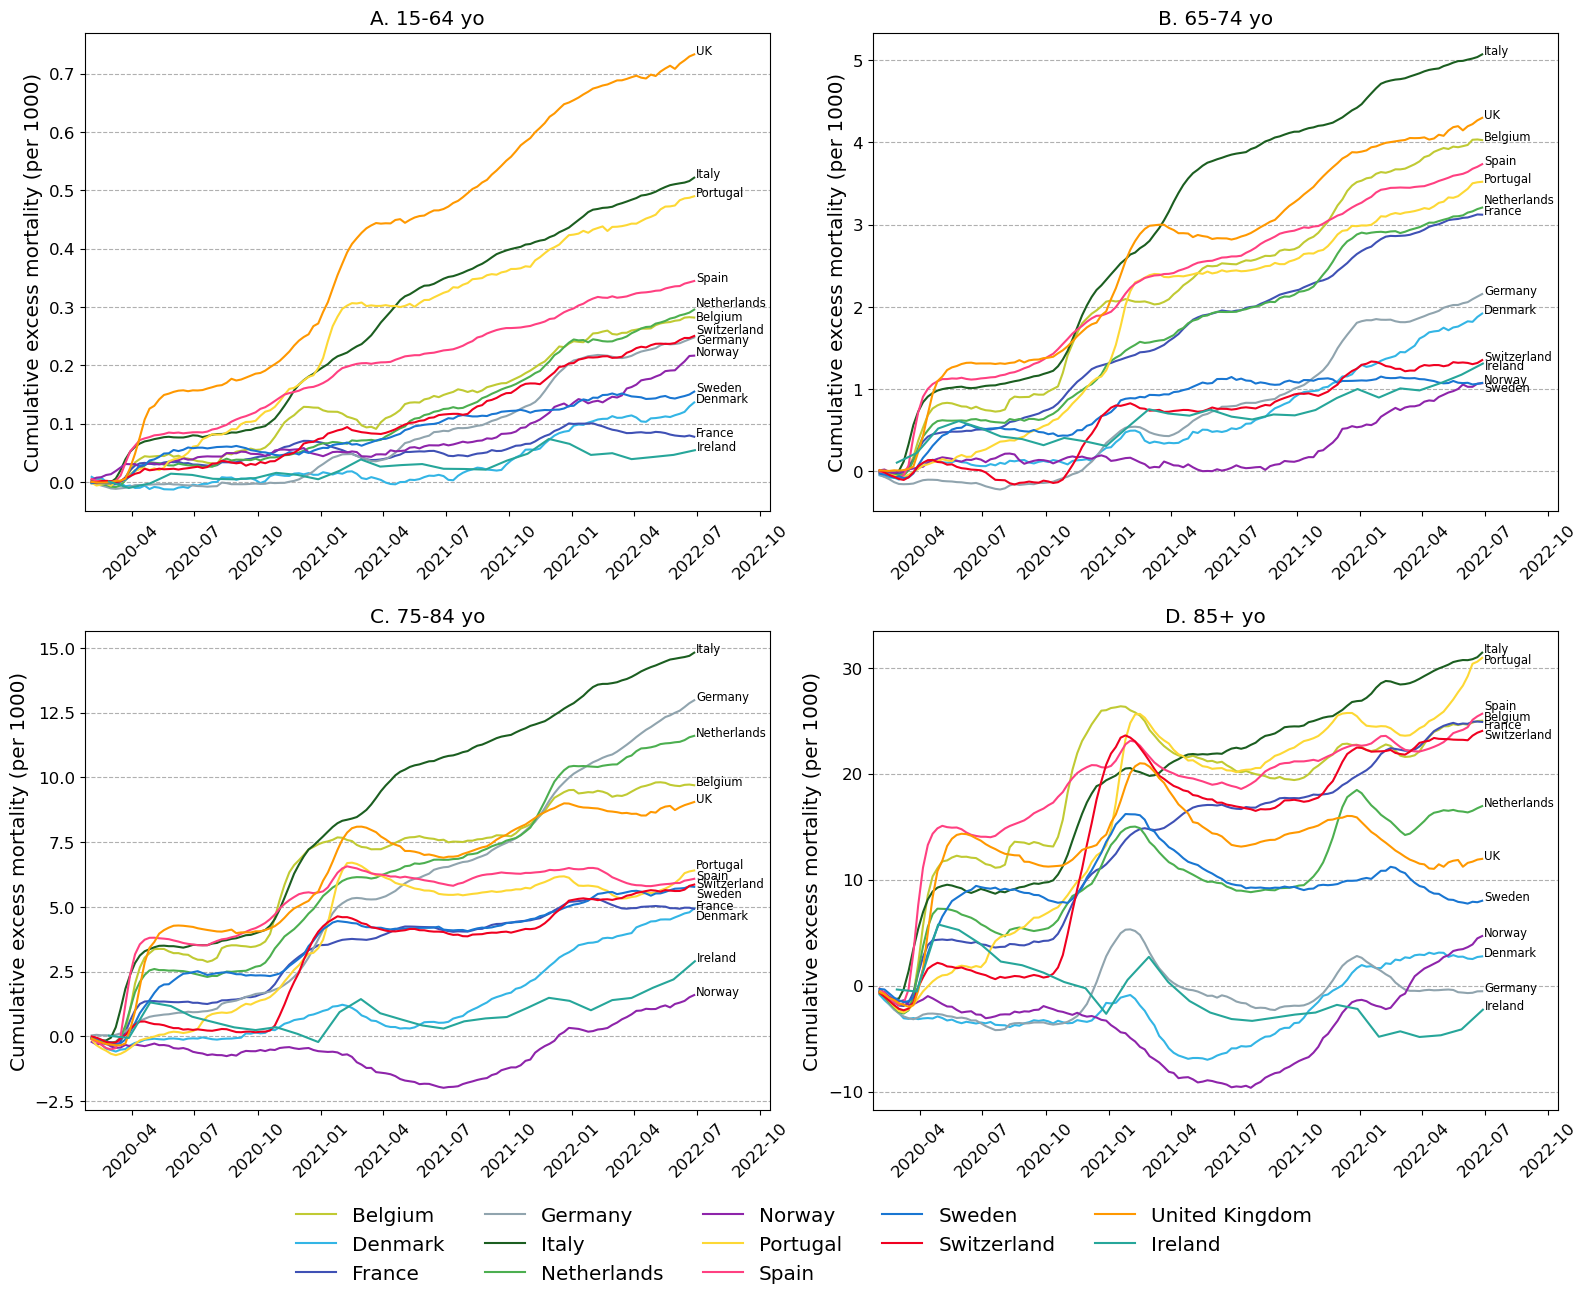

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
col = 'Cumulative Excess From w5y2020 to w26y2022'
#title_1 = 'A. Total (not stratified) cummulative excess mortality \n2020-2022 projection - 10 years reference \nWeek 5 2020 to Week 26 2022'
#title_2 = 'B. 0-14yo cummulative excess mortality \n2020-2022 projection - 10 years reference \nWeek 5 2020 to Week 26 2022'
title_3 = 'A. 15-64 yo'
title_4 = 'B. 65-74 yo'
title_5 = 'C. 75-84 yo'
title_6 = 'D. 85+ yo'

#plot_df_diff(axs[0,0], data_excess_20_21_22_not_standardised_diff[data_excess_20_21_22_not_standardised_diff['Age cat']=='Total'], title=title_1,colname=col,d_beg=10, d_end=155)
#plot_df_diff(axs[2,1], data_excess_20_21_22_not_standardised_diff[data_excess_20_21_22_not_standardised_diff['Age cat']=='0-14'], data_excess_20_21_22_not_standardised_diff_ireland[data_excess_20_21_22_not_standardised_diff_ireland['Age cat']=='0-14'], title=title_2,colname=col,d_beg=10, d_end=155)
dic_position={'Belgium':-0.005, 'Denmark':0, 'France':0, 'Germany':-0.01, 'Ireland':0, 'Italy':0, 'Netherlands':0.005, 'Norway':0, 'Portugal':0, 'Spain':0, 'Sweden':0, 'Switzerland':0.005, 'United Kingdom':0, 'England':0}
plot_df_diff(axs[0,0], data_excess_20_21_22_not_standardised_diff[data_excess_20_21_22_not_standardised_diff['Age cat']=='15-64'], data_excess_20_21_22_not_standardised_diff_ireland[data_excess_20_21_22_not_standardised_diff_ireland['Age cat']=='15-64'], title=title_3,colname=col,d_beg=10, d_end=110, dic_position=dic_position)

dic_position={'Belgium':0, 'Denmark':0, 'France':0, 'Germany':0, 'Ireland':-0.07, 'Italy':0, 'Netherlands':0.05, 'Norway':0, 'Portugal':0, 'Spain':0, 'Sweden':-0.1, 'Switzerland':0, 'United Kingdom':0, 'England':0}
plot_df_diff(axs[0,1], data_excess_20_21_22_not_standardised_diff[data_excess_20_21_22_not_standardised_diff['Age cat']=='65-74'], data_excess_20_21_22_not_standardised_diff_ireland[data_excess_20_21_22_not_standardised_diff_ireland['Age cat']=='65-74'], title=title_4,colname=col,d_beg=10, d_end=110, dic_position=dic_position)

dic_position={'Belgium':0, 'Denmark':-0.4, 'France':0, 'Germany':0, 'Ireland':0, 'Italy':0, 'Netherlands':0, 'Norway':0, 'Portugal':0.1, 'Spain':0, 'Sweden':-0.4, 'Switzerland':-0.1, 'United Kingdom':0, 'England':0}
plot_df_diff(axs[1,0], data_excess_20_21_22_not_standardised_diff[data_excess_20_21_22_not_standardised_diff['Age cat']=='75-84'], data_excess_20_21_22_not_standardised_diff_ireland[data_excess_20_21_22_not_standardised_diff_ireland['Age cat']=='75-84'], title=title_5,colname=col,d_beg=10, d_end=110, dic_position=dic_position)

dic_position={'Belgium':0, 'Denmark':0, 'France':-0.6, 'Germany':0, 'Ireland':0, 'Italy':0, 'Netherlands':0, 'Norway':0, 'Portugal':-0.5, 'Spain':0.4, 'Sweden':0, 'Switzerland':-0.7, 'United Kingdom':0, 'England':0}
plot_df_diff(axs[1,1], data_excess_20_21_22_not_standardised_diff[data_excess_20_21_22_not_standardised_diff['Age cat']=='85+'], data_excess_20_21_22_not_standardised_diff_ireland[data_excess_20_21_22_not_standardised_diff_ireland['Age cat']=='85+'], title=title_6,colname=col,d_beg=10, d_end=110, dic_position=dic_position)

# Réglages globaux
#plt.suptitle('Fig.1',fontsize='xx-large')
plt.tight_layout()
leg = plt.legend(loc='lower center',bbox_to_anchor=(-0.1, -0.4), ncol=5,fontsize='x-large',frameon=False)
plt.subplots_adjust(wspace=0.15, hspace=0.25)
#plt.savefig("C:\\Users\\ccoustau\\Documents\\fig1_v4.png", bbox_inches='tight')
plt.show()

# Sensitivity analysis

In [61]:
def ASMR_predicted_2019(data_annual_ASMR, countries):
    num_countries = len(countries)
    
    # Calculate the number of rows needed based on the 3 columns layout
    num_rows = (num_countries + 2) // 3
    
    # Set up subplots with 3 columns
    fig, axs = plt.subplots(num_rows, 3, figsize=(15,  3* num_rows+2))
    axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array

    for i, t in enumerate(countries):
        ymin = 2010
        if t == 'Italy':
            ymin = 2011

        mask10 = (data_annual_ASMR['Year'] >= ymin) & (data_annual_ASMR['Year'] <= 2019) & (data_annual_ASMR['Country'] == t)
        mask5 = (data_annual_ASMR['Year'] >= 2015) & (data_annual_ASMR['Year'] <= 2019) & (data_annual_ASMR['Country'] == t)
        y_10 = np.array(data_annual_ASMR[mask10]['Year'])
        ASMR_y_10 = np.array(data_annual_ASMR[mask10]['Annual ASMR'])*1000
        
        y_5 = np.array(data_annual_ASMR[mask5]['Year'])
        ASMR_y_5 = np.array(data_annual_ASMR[mask5]['Annual ASMR'])*1000

        ASMR_y_log_10 = np.log(ASMR_y_10)
        ASMR_y_log_5 = np.log(ASMR_y_5)

        y_5 = y_5.reshape(-1, 1)
        y_10 = y_10.reshape(-1, 1)
        ASMR_y_log_5 = ASMR_y_log_5.reshape(-1, 1)
        ASMR_y_log_10 = ASMR_y_log_10.reshape(-1, 1)

        model_5 = LinearRegression()
        model_5.fit(y_5, ASMR_y_5)
        model_10 = LinearRegression()
        model_10.fit(y_10, ASMR_y_10)
        model_5_log = LinearRegression()
        model_5_log.fit(y_5, ASMR_y_log_5)
        model_10_log = LinearRegression()
        model_10_log.fit(y_10, ASMR_y_log_10)

        y = np.array(data_annual_ASMR[(data_annual_ASMR['Year'] >= ymin) & (data_annual_ASMR['Year'] <= 2023)
                                      & (data_annual_ASMR['Country'] == t)]['Year'])
        ASMR_y = np.array(data_annual_ASMR[(data_annual_ASMR['Year'] >= ymin) & (data_annual_ASMR['Year'] <= 2023)
                                           & (data_annual_ASMR['Country'] == t)]['Annual ASMR'])*1000
        y = y.reshape(-1, 1)
        ASMR_y = ASMR_y.reshape(-1, 1)
        
        ASMR_y_pred_log_10 = model_10_log.predict(y)
        ASMR_y_pred_10_log = np.exp(ASMR_y_pred_log_10)
        ASMR_y_pred_log_5 = model_5_log.predict(y)
        ASMR_y_pred_5_log = np.exp(ASMR_y_pred_log_5)
        ASMR_y_pred_10 = model_10.predict(y)
        ASMR_y_pred_5 = model_5.predict(y)
        
        # Add slope information to the plot
        #slope_text = f'β={model.coef_[0][0]:.3f}'
        #axs[i].text(0.05, 0.9, slope_text, transform=axs[i].transAxes, color='red', fontsize='xx-large')


        axs[i].scatter(y, ASMR_y, label='Age- and sex-standardised mortality rate - 2010-2019 (reference period)', color='black')
        axs[i].scatter(y[-3:], ASMR_y[-3:], label='Age- and sex-standardised mortality rate - 2020-2022', color='red')
        #axs[i].plot(y, ASMR_y_pred_10, label='Linear Trend \nbased on year ' + str(ymin)+ '-2019', color='Blue')
        #axs[i].plot(y, ASMR_y_pred_5, label='Linear Trend \nbased on year 2015-2019', color='cyan')
        axs[i].plot(y, ASMR_y_pred_10_log, label='Log-linear trend based on age- and sex-standardised rates from 2010 to 2019', color='magenta')
        axs[i].plot(y, ASMR_y_pred_5_log, label='Log-linear trend based on age- and sex-standardised rates from 2015 to 2019', color='cyan')
        axs[i].set_xlabel('Year')
        axs[i].set_ylim(7,12)
        axs[i].set_ylabel('Mortality Rate \n(per 1000)', fontsize='large')
        axs[i].set_title(t, fontsize='x-large')
        #axs[i].legend()

    # Remove any empty subplots if the number of countries is not a multiple of 3
    for j in range(num_countries, num_rows * 3):
        fig.delaxes(axs[j])
    
    #plt.suptitle('Annual Age-standardised mortality rates and log-linear mortality trend', fontsize='xx-large')
    plt.tight_layout(h_pad=0.1)
    leg = plt.legend(loc='lower center',bbox_to_anchor=(2.3, 0.2), ncol=1,fontsize='x-large',frameon=False)
    #plt.subplots_adjust(hspace=0.5)
    plt.show()

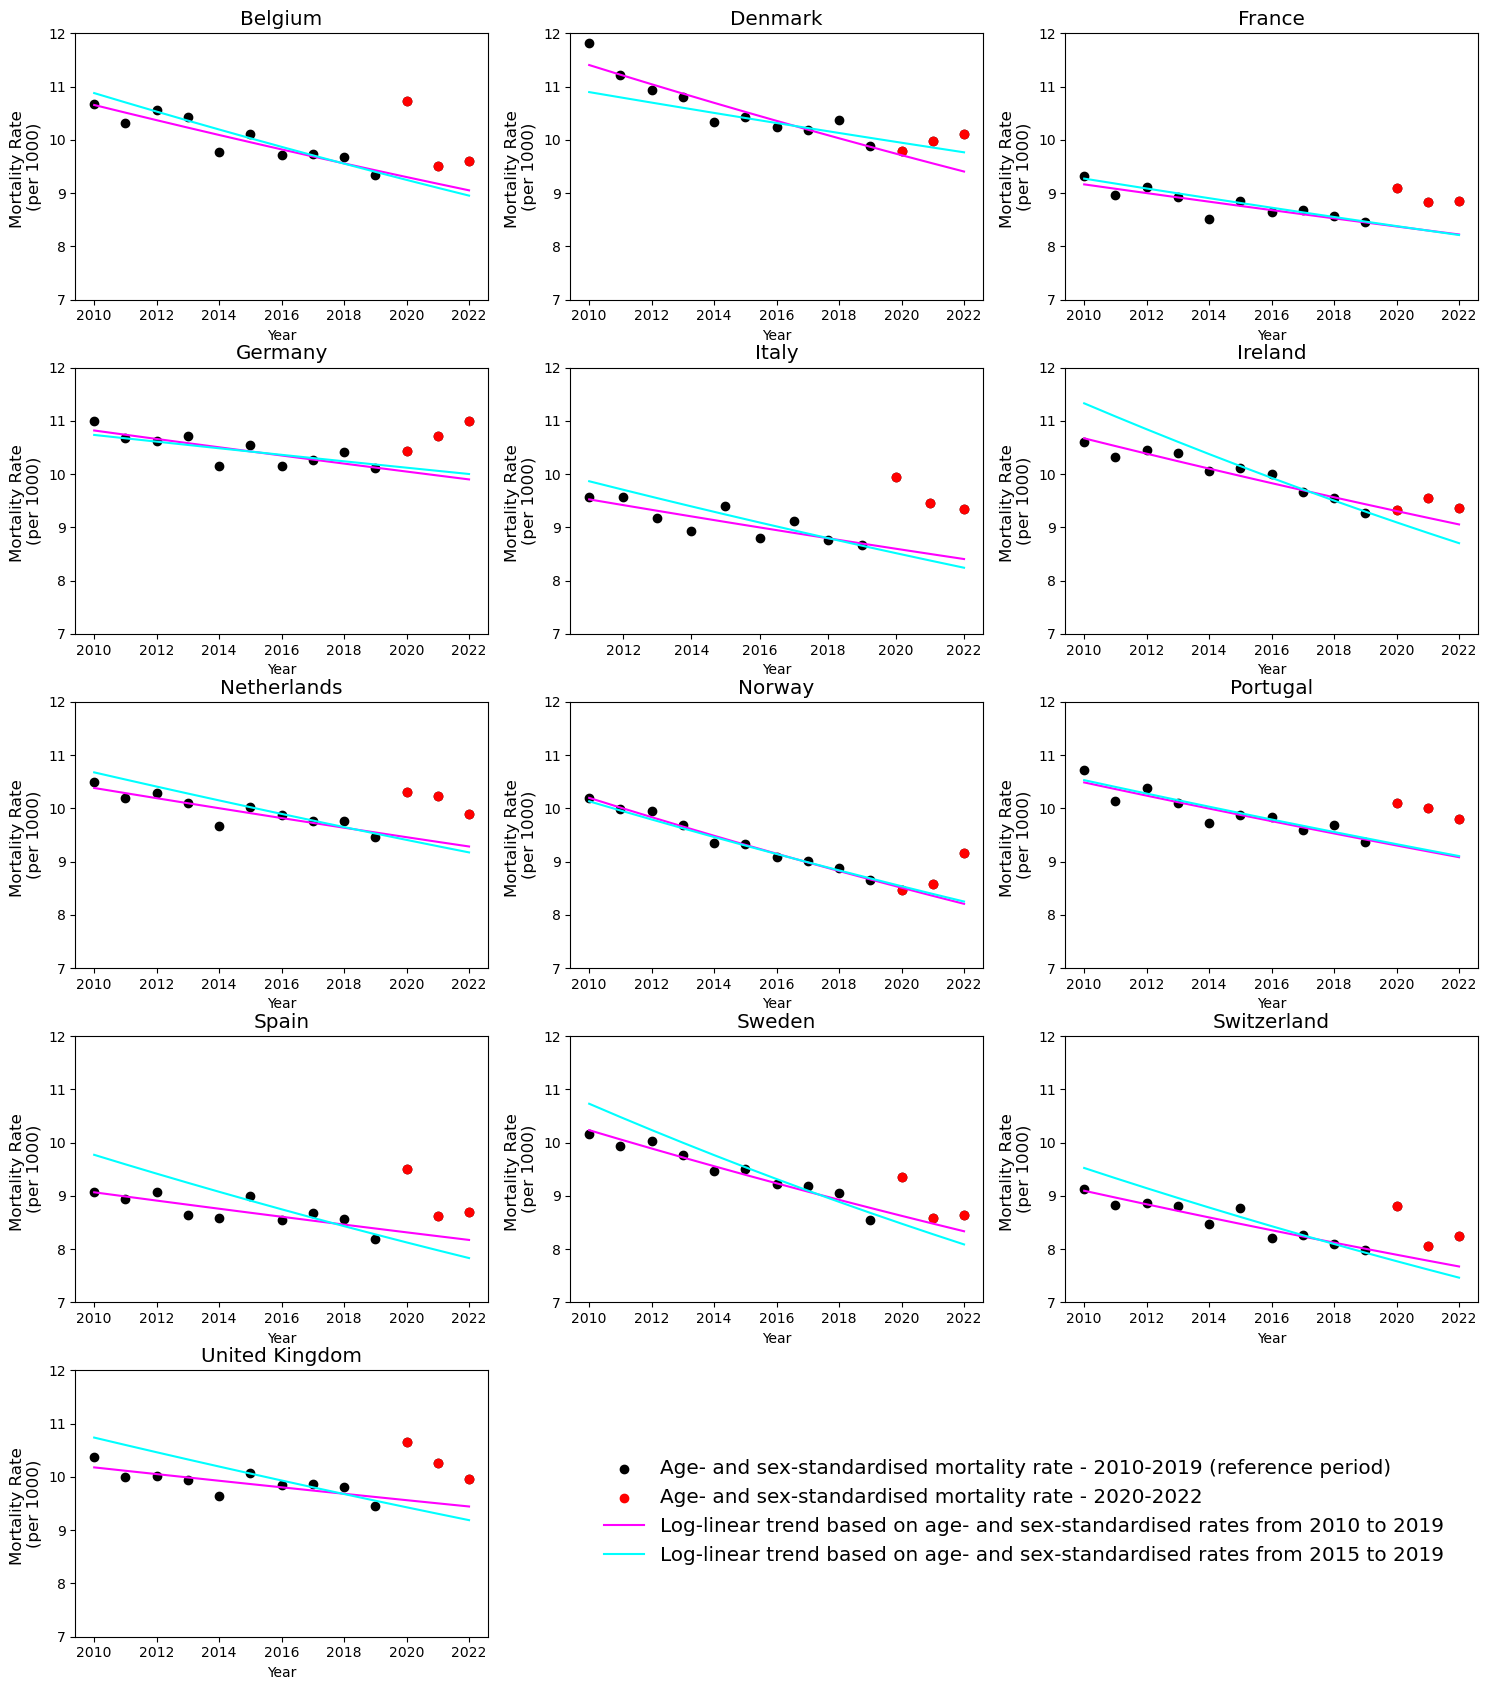

In [62]:
ASMR_predicted_2019(data_annual_ASMR, Country_ireland)